In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.preprocessing import RobustScaler

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov 30 09:03:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   42C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
train=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/megahack1/train.csv')
train_bkp=train.copy()

In [5]:
test=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/megahack1/test.csv')
test_bkp=test.copy()

In [6]:
train.shape , test.shape

((381109, 12), (127037, 11))

In [7]:
train.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [9]:
ignored_cols=['Response','id']
for col in train.drop(columns=ignored_cols):
    print( " {}-{} contains {} values and values are {}".format(col,(train[col].dtype),train[col].nunique(),train[col].unique()))

 Gender-object contains 2 values and values are ['Male' 'Female']
 Age-int64 contains 66 values and values are [44 76 47 21 29 24 23 56 32 41 71 37 25 42 60 65 49 34 51 26 57 79 48 45
 72 30 54 27 38 22 78 20 39 62 58 59 63 50 67 77 28 69 52 31 33 43 36 53
 70 46 55 40 61 75 64 35 66 68 74 73 84 83 81 80 82 85]
 Driving_License-int64 contains 2 values and values are [1 0]
 Region_Code-float64 contains 53 values and values are [28.  3. 11. 41. 33.  6. 35. 50. 15. 45.  8. 36. 30. 26. 16. 47. 48. 19.
 39. 23. 37.  5. 17.  2.  7. 29. 46. 27. 25. 13. 18. 20. 49. 22. 44.  0.
  9. 31. 12. 34. 21. 10. 14. 38. 24. 40. 43. 32.  4. 51. 42.  1. 52.]
 Previously_Insured-int64 contains 2 values and values are [0 1]
 Vehicle_Age-object contains 3 values and values are ['> 2 Years' '1-2 Year' '< 1 Year']
 Vehicle_Damage-object contains 2 values and values are ['Yes' 'No']
 Annual_Premium-float64 contains 48838 values and values are [ 40454.  33536.  38294. ...  20706. 101664.  69845.]
 Policy_Sales_Ch

In [10]:
disc_cols=['Gender','Driving_License','Region_Code','Previously_Insured','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel']
conti_cols=['Age','Annual_Premium','Vintage']
target_col=["Response"]

In [11]:
train.isna().sum()

,0
id,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0


In [12]:
num_cols=[ col for col in train.select_dtypes(exclude='object').columns.tolist() if col not in (ignored_cols)]

In [13]:
num_cols

['Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage']

In [14]:
cat_cols=[ col for col in train.select_dtypes(include='object').columns.tolist() if col not in (ignored_cols)]

In [15]:
cat_cols

['Gender', 'Vehicle_Age', 'Vehicle_Damage']

In [16]:


train.Response.value_counts()

,count
Response,
0,334399
1,46710


In [17]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
Driving_License,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
Region_Code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
Previously_Insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
Annual_Premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
Policy_Sales_Channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
Response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


# Inference
1. Data Variability: A standard deviation of 17,213 suggests significant variability in the dataset. This could indicate that the data includes extreme values or outliers, which can skew the results and affect interpretations. indicating a diverse customer base with potentially different risk profiles or coverage needs.For instance, if certain customers are paying significantly higher premiums, it may reflect their higher risk factors (e.g., age, health status). Conversely, lower premiums might be associated with lower-risk individuals. This variability is crucial for insurers in assessing overall risk and setting appropriate premium rates.
2. Average age of the customer is 38 years .
3_ Region_152 has highest customer with


**Visulization of Distribution**

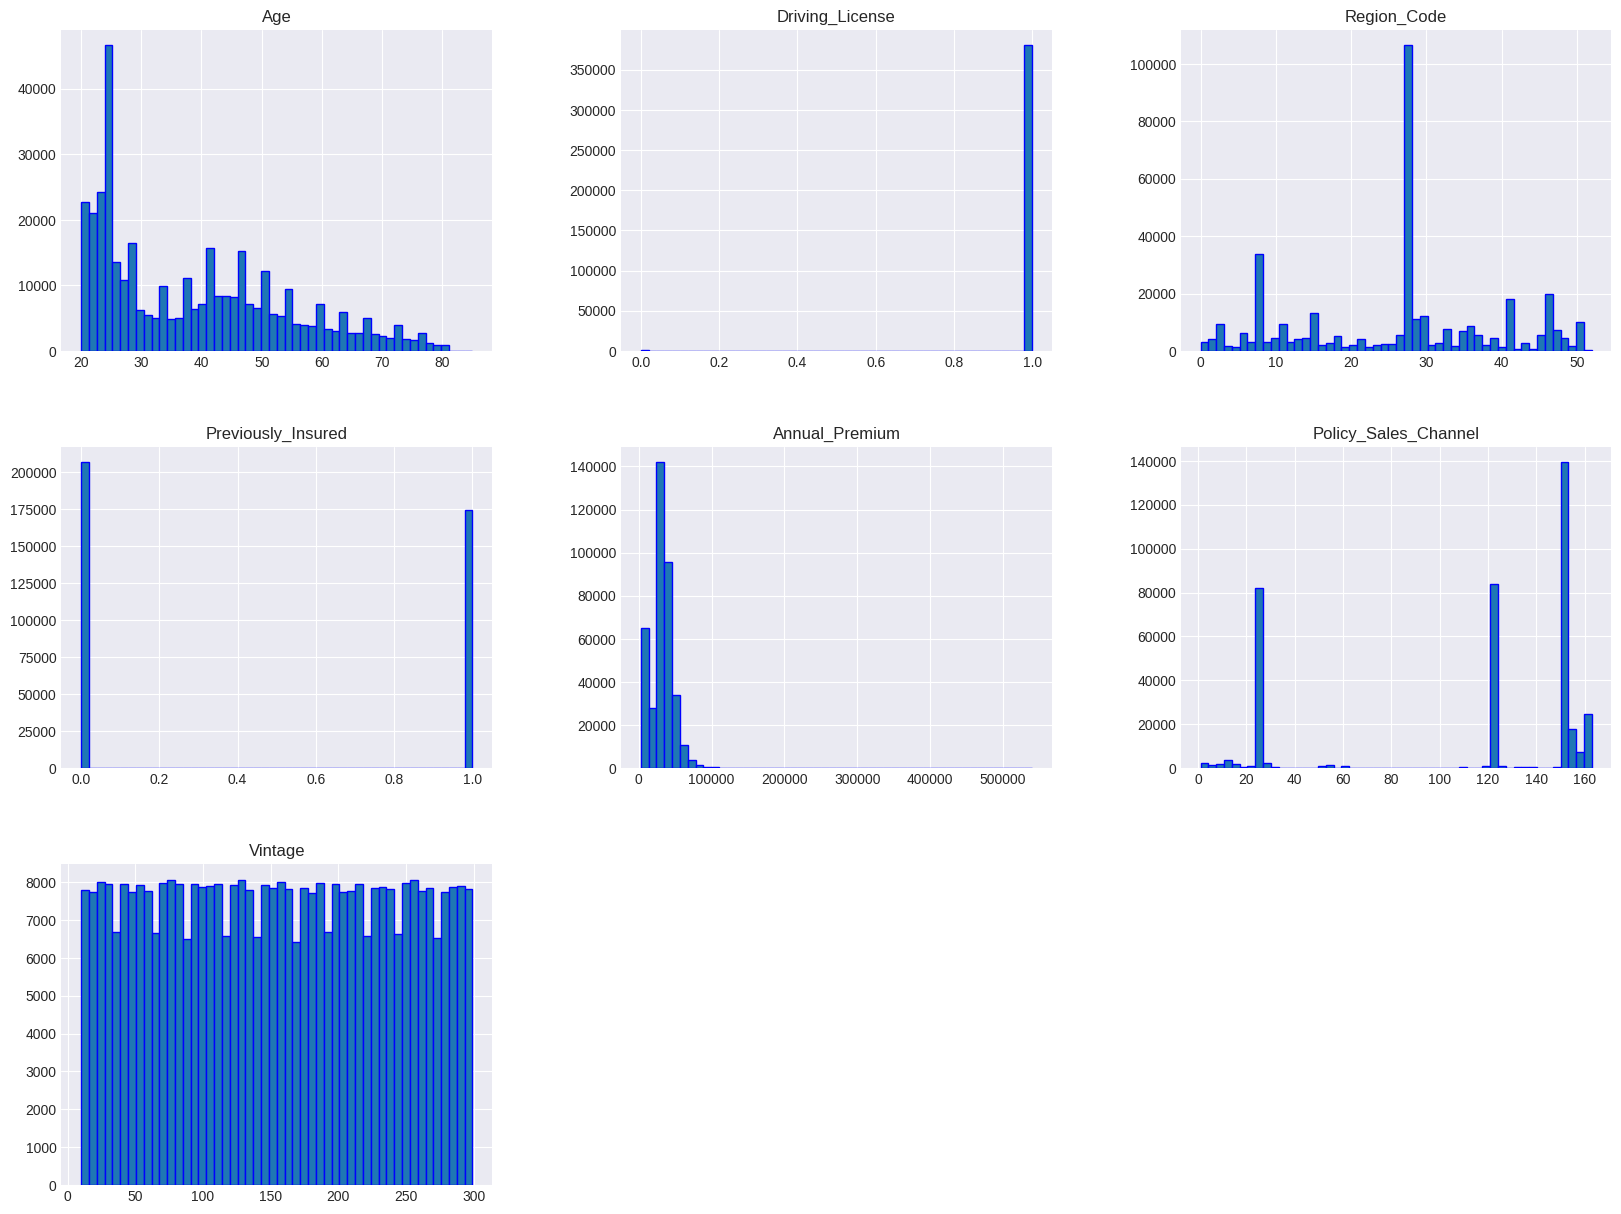

In [18]:
# PLot density plot for all features
plt.style.use('seaborn-v0_8-darkgrid')
train.drop(columns=ignored_cols,axis=1).hist(bins=50, figsize=(20,15), ec = 'b')
plt.show()

In [19]:
train.Policy_Sales_Channel.value_counts().sort_values(ascending=False)

,count
Policy_Sales_Channel,
152.0,134784
26.0,79700
124.0,73995
160.0,21779
156.0,10661
...,...
149.0,1
123.0,1
144.0,1


In [20]:
pd.set_option('display.max_rows', 50)

In [21]:
train.Age.value_counts().sort_values(ascending=False)

,count
Age,
24,25960
23,24256
22,20964
25,20636
21,16457
...,...
81,56
82,29
83,22


In [22]:
train.Driving_License.value_counts(normalize=True).sort_values(ascending=False)

,proportion
Driving_License,
1,0.997869
0,0.002131


In [23]:
train.Previously_Insured.value_counts(normalize=True).sort_values(ascending=False)

,proportion
Previously_Insured,
0,0.54179
1,0.45821


In [24]:
train.Annual_Premium.value_counts(normalize=True).sort_values(ascending=False)

,proportion
Annual_Premium,
2630.0,0.170232
69856.0,0.000367
39008.0,0.000108
38287.0,0.000100
45179.0,0.000100
...,...
99997.0,0.000003
17432.0,0.000003
80396.0,0.000003


In [25]:
train.Region_Code.value_counts(normalize=True).sort_values(ascending=False)

,proportion
Region_Code,
28.0,0.279225
8.0,0.088891
46.0,0.051820
41.0,0.047921
15.0,0.034919
...,...
1.0,0.002645
44.0,0.002120
42.0,0.001551


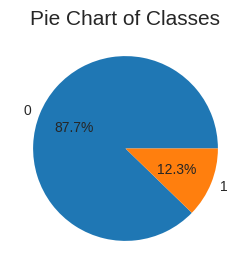

In [26]:
# Percentage for PieChart
percentage = train.Response.value_counts(normalize=True)*100
percentage
#plotting PieChart
classeslabels = [0, 1]
plt.figure(figsize =(3, 3))
plt.pie(percentage,labels = classeslabels,autopct='%1.1f%%')
plt.title ("Pie Chart of Classes", fontsize = 15)
plt.show()

In [27]:
train.Response.value_counts()

,count
Response,
0,334399
1,46710


**Checking Multicollinearity**

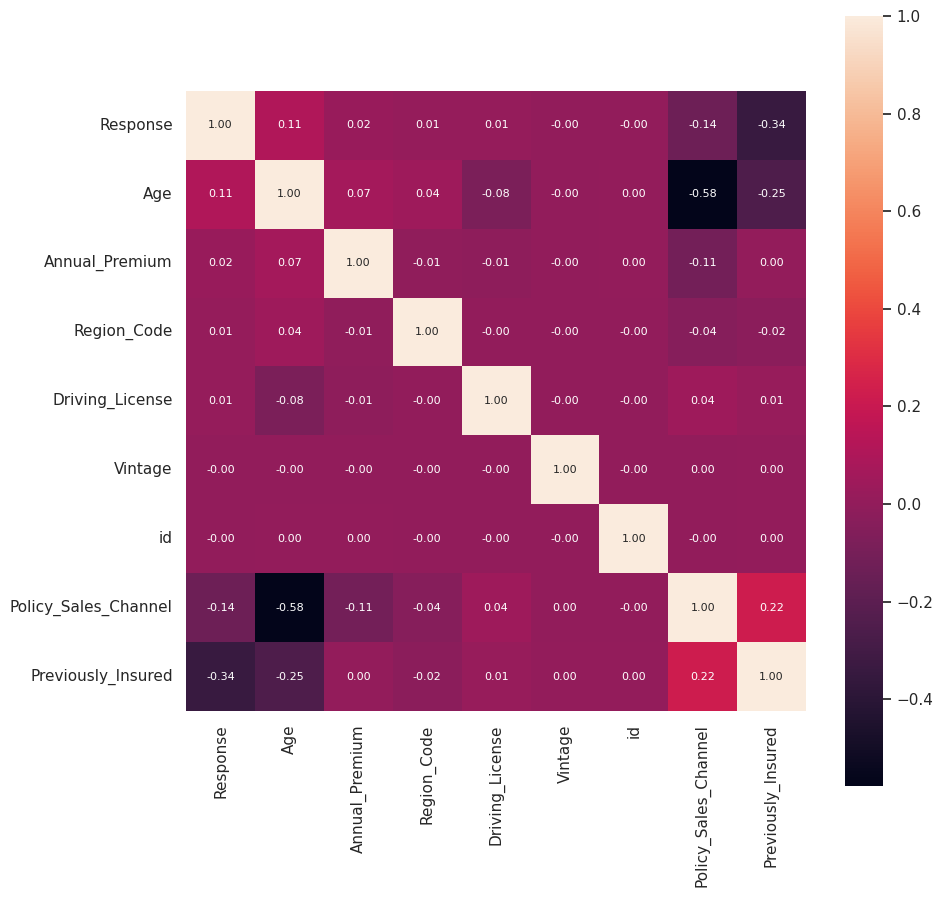

In [28]:
# Correlation chart
k = len(train.columns)
# Get the indices of the columns with the largest correlation with 'Response'
numerical_cols = train.select_dtypes(include=np.number).columns
cols = train[numerical_cols].corr()['Response'].nlargest(k).index
#cols
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(10, 10))
hm = sns.heatmap(cm, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

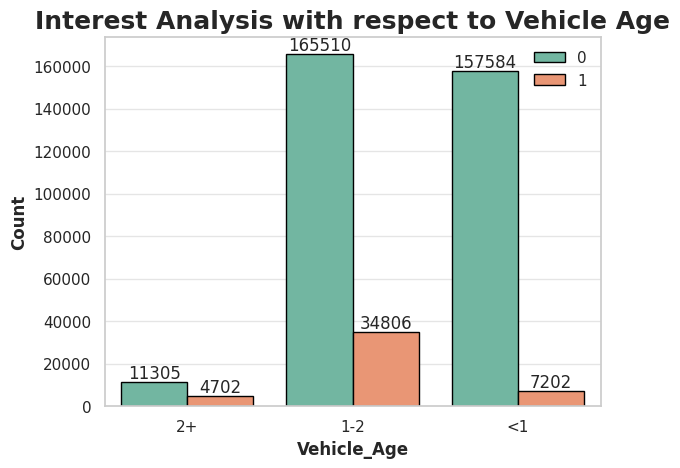

In [29]:
# dftemp= train.loc[df['Region']== 1]
# plt.subplots(figsize=(13,6))
sns.set_style('whitegrid')
a=sns.countplot(x='Vehicle_Age',hue='Response',data= train,ec = 'black', palette= 'Set2')
# a.bar_label(a.containers[0])
for container in a.containers:
    a.bar_label(container)
plt.title('Interest Analysis with respect to Vehicle Age', fontsize=18, weight='bold')
plt.ylabel('Count', weight = 'bold')
plt.xlabel('Vehicle_Age', weight= 'bold')
plt.legend(loc='upper right')
plt.xticks(np.arange(3), ['2+','1-2','<1'])
plt.grid(alpha = 0.5,axis = 'y')
plt.show()

In [30]:
def barchart(feature,xlabel):
    plt.figure(figsize=[4,5])
    by_feature =  train.groupby([feature], as_index=False)['Response'].sum()
    ax = sns.barplot(x=feature, y="Response", data=by_feature[[feature,'Response']], estimator=sum)
    ax.set(xlabel=xlabel, ylabel='Interest Count')
    for container in ax.containers:
      ax.bar_label(container)

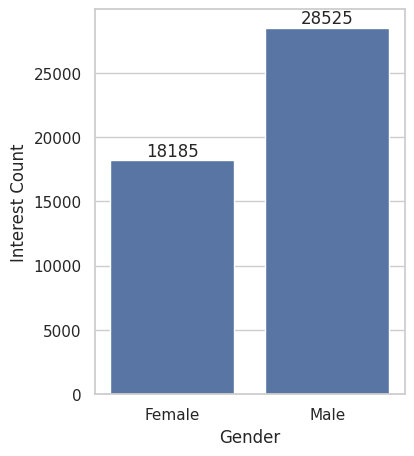

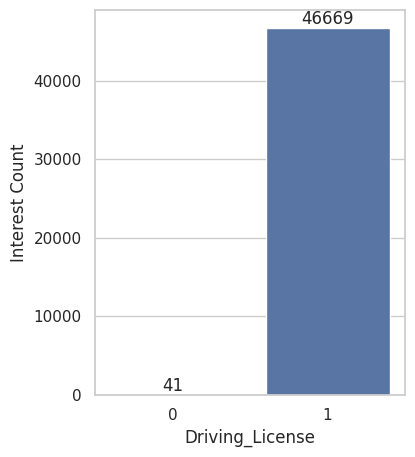

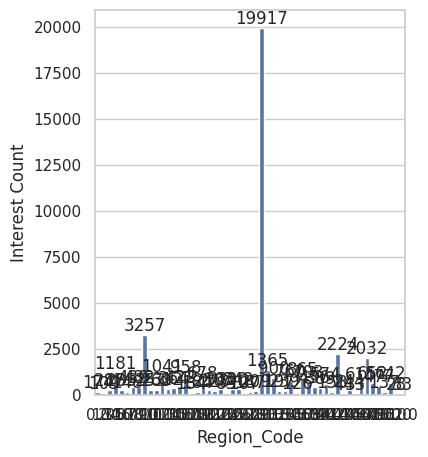

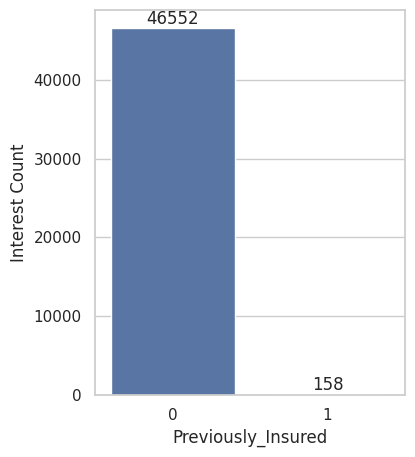

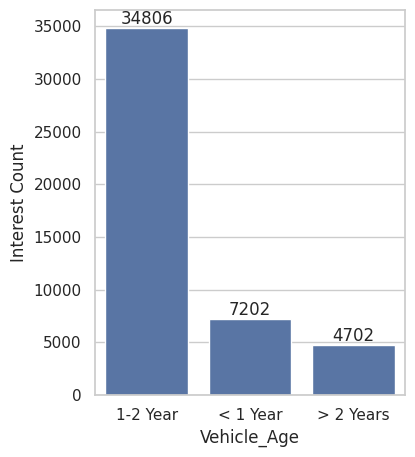

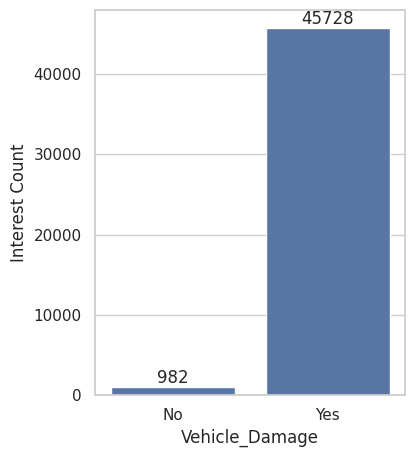

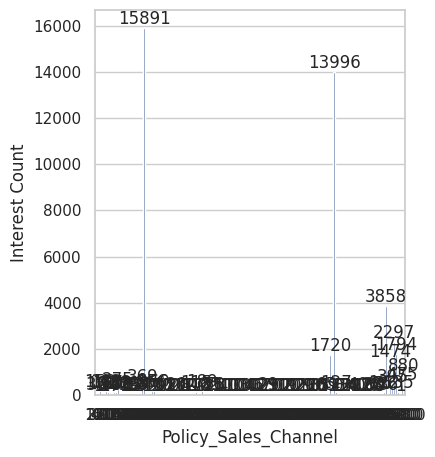

In [31]:
for col in disc_cols:
    barchart(col,col)

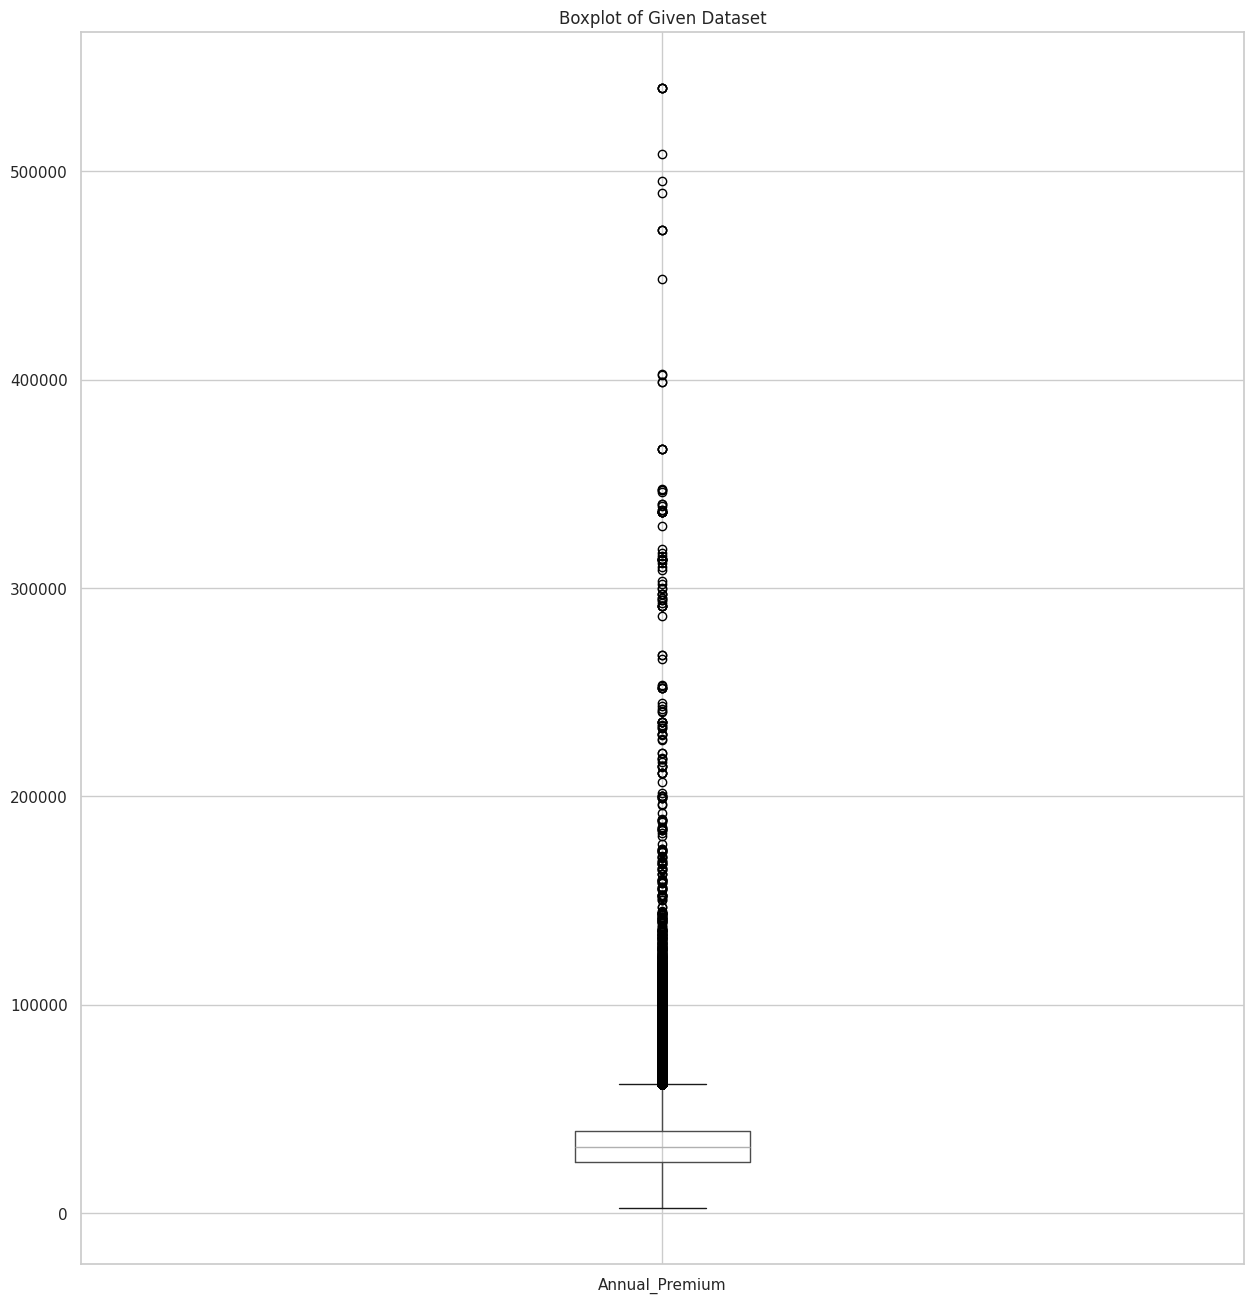

In [32]:
fig = plt.figure(figsize =(15, 16))
ax = train[['Annual_Premium']].boxplot()
ax.set_title("Boxplot of Given Dataset")
plt.show()

In [33]:
train[train['Annual_Premium']>300000]['Response'].value_counts()

,count
Response,
0,42
1,9


In [34]:
filtered_train = train[train['Annual_Premium'] < 200000]

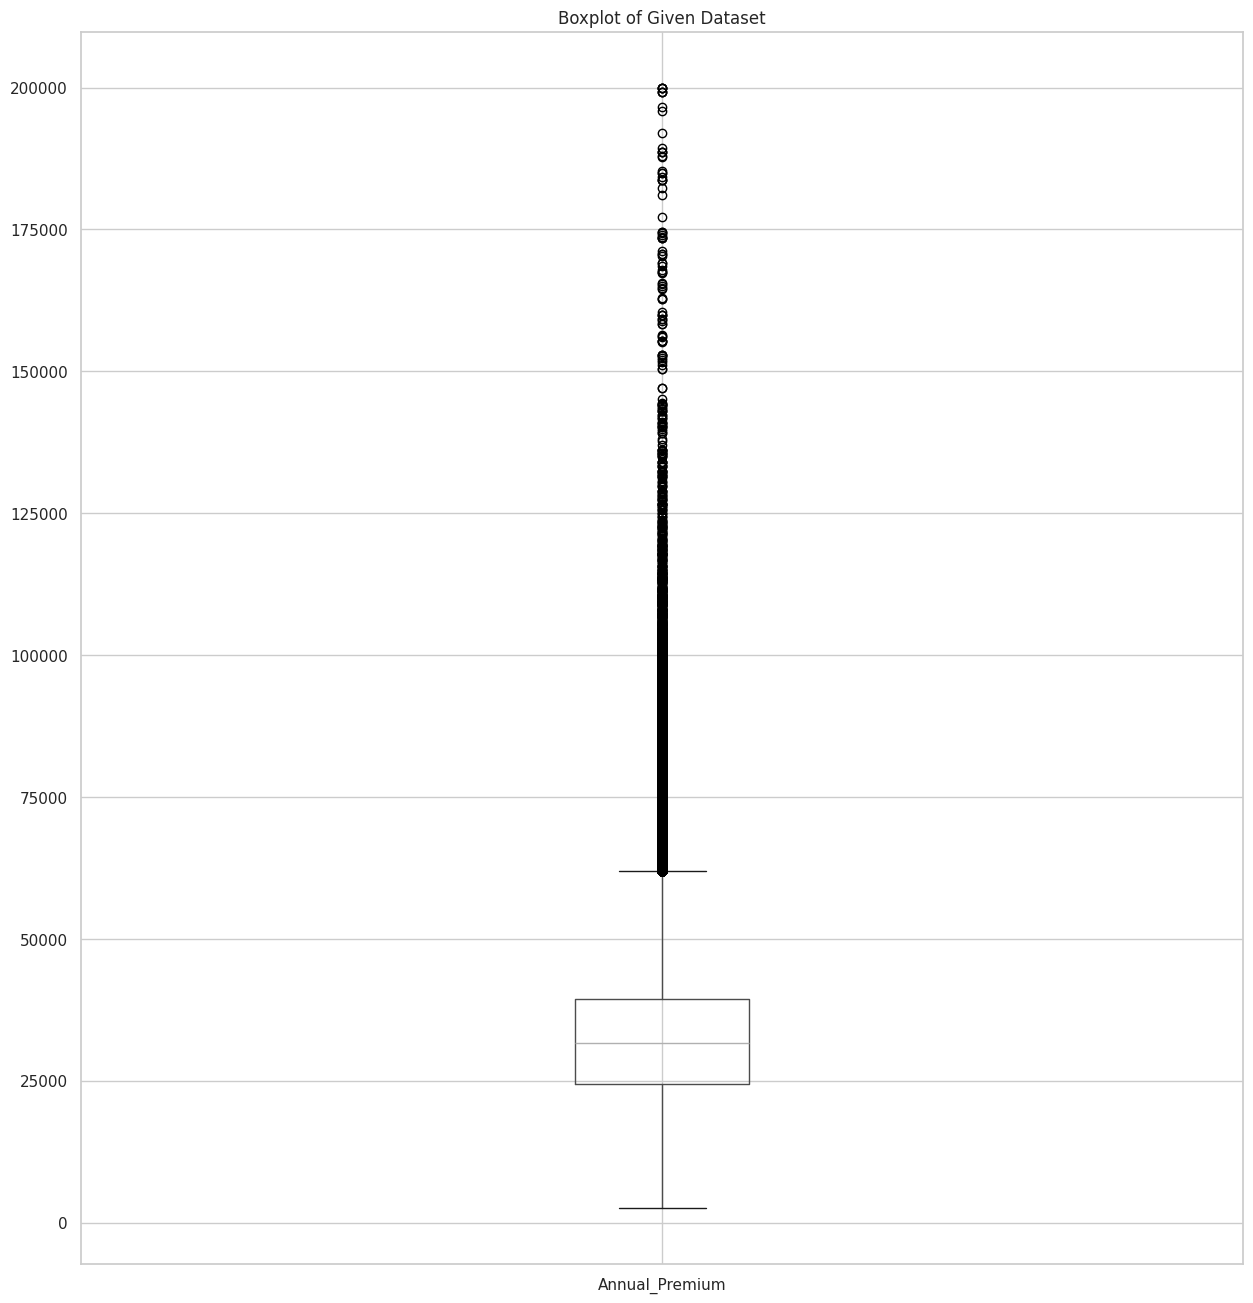

In [35]:
fig = plt.figure(figsize =(15, 16))
ax = filtered_train[['Annual_Premium']].boxplot()
ax.set_title("Boxplot of Given Dataset")
plt.show()

In [36]:
import pandas as pd
import numpy as np

# Sample DataFrame
data = {'annual_premium': [2630, 5000, 10000, 20000, 30000, 500000]}
train1 = pd.DataFrame(data)

# Apply log transformation
train1['log_annual_premium'] = np.log(train1['annual_premium'])

print(train1)

   annual_premium  log_annual_premium
0            2630            7.874739
1            5000            8.517193
2           10000            9.210340
3           20000            9.903488
4           30000           10.308953
5          500000           13.122363


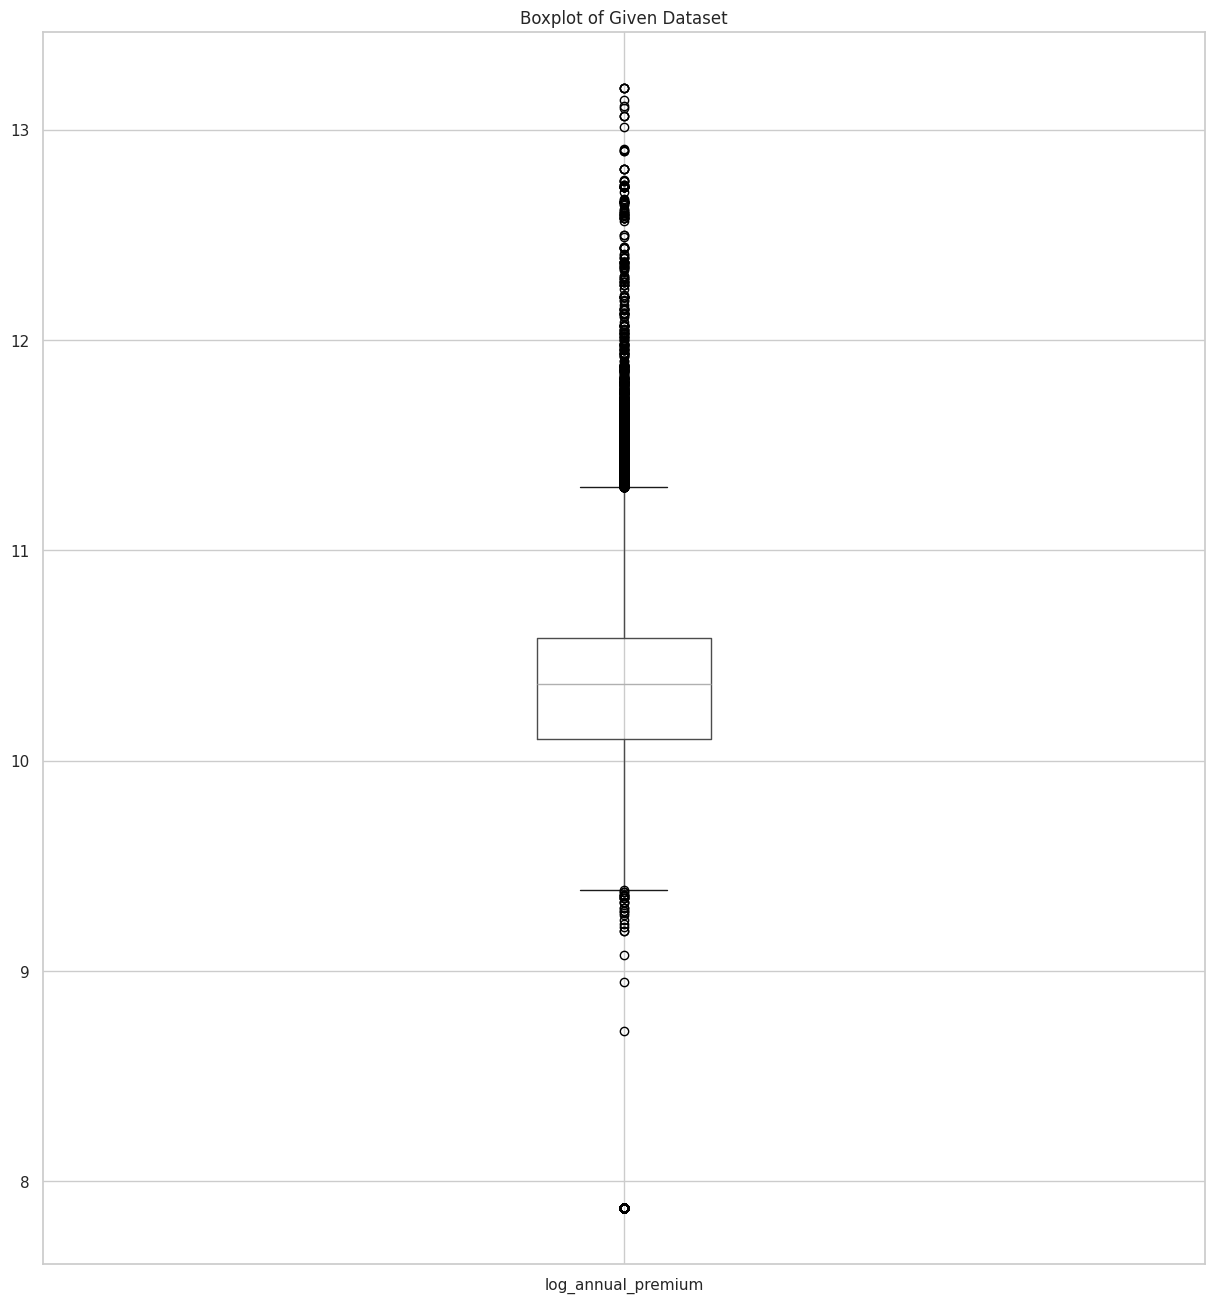

In [37]:
fig = plt.figure(figsize =(15, 16))
train2=train
train2['log_annual_premium']=np.log(train2['Annual_Premium'])
ax = train2[['log_annual_premium']].boxplot()
ax.set_title("Boxplot of Given Dataset")
plt.show()

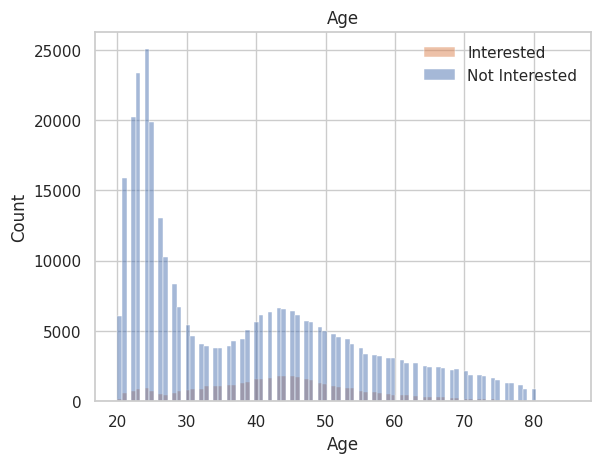

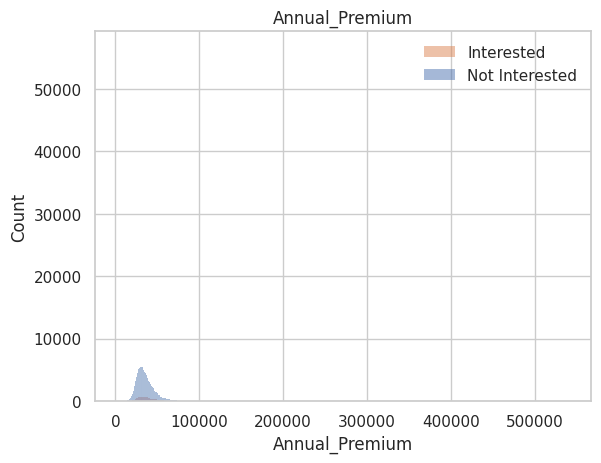

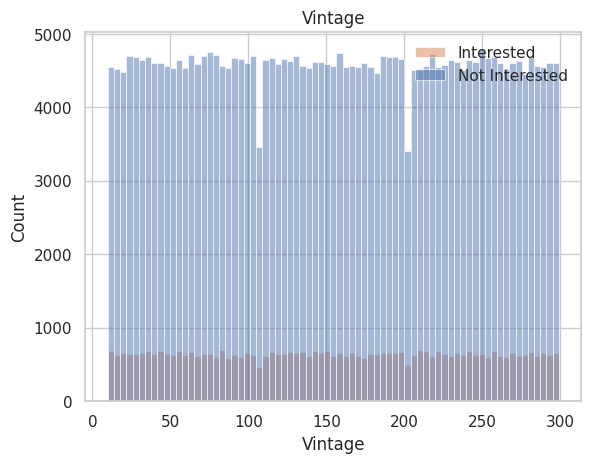

In [38]:
for feature in conti_cols:
    sns.histplot(data = train,x=feature, hue = 'Response')
    plt.legend(labels=['Interested','Not Interested'])
    plt.title(feature)
    plt.show()

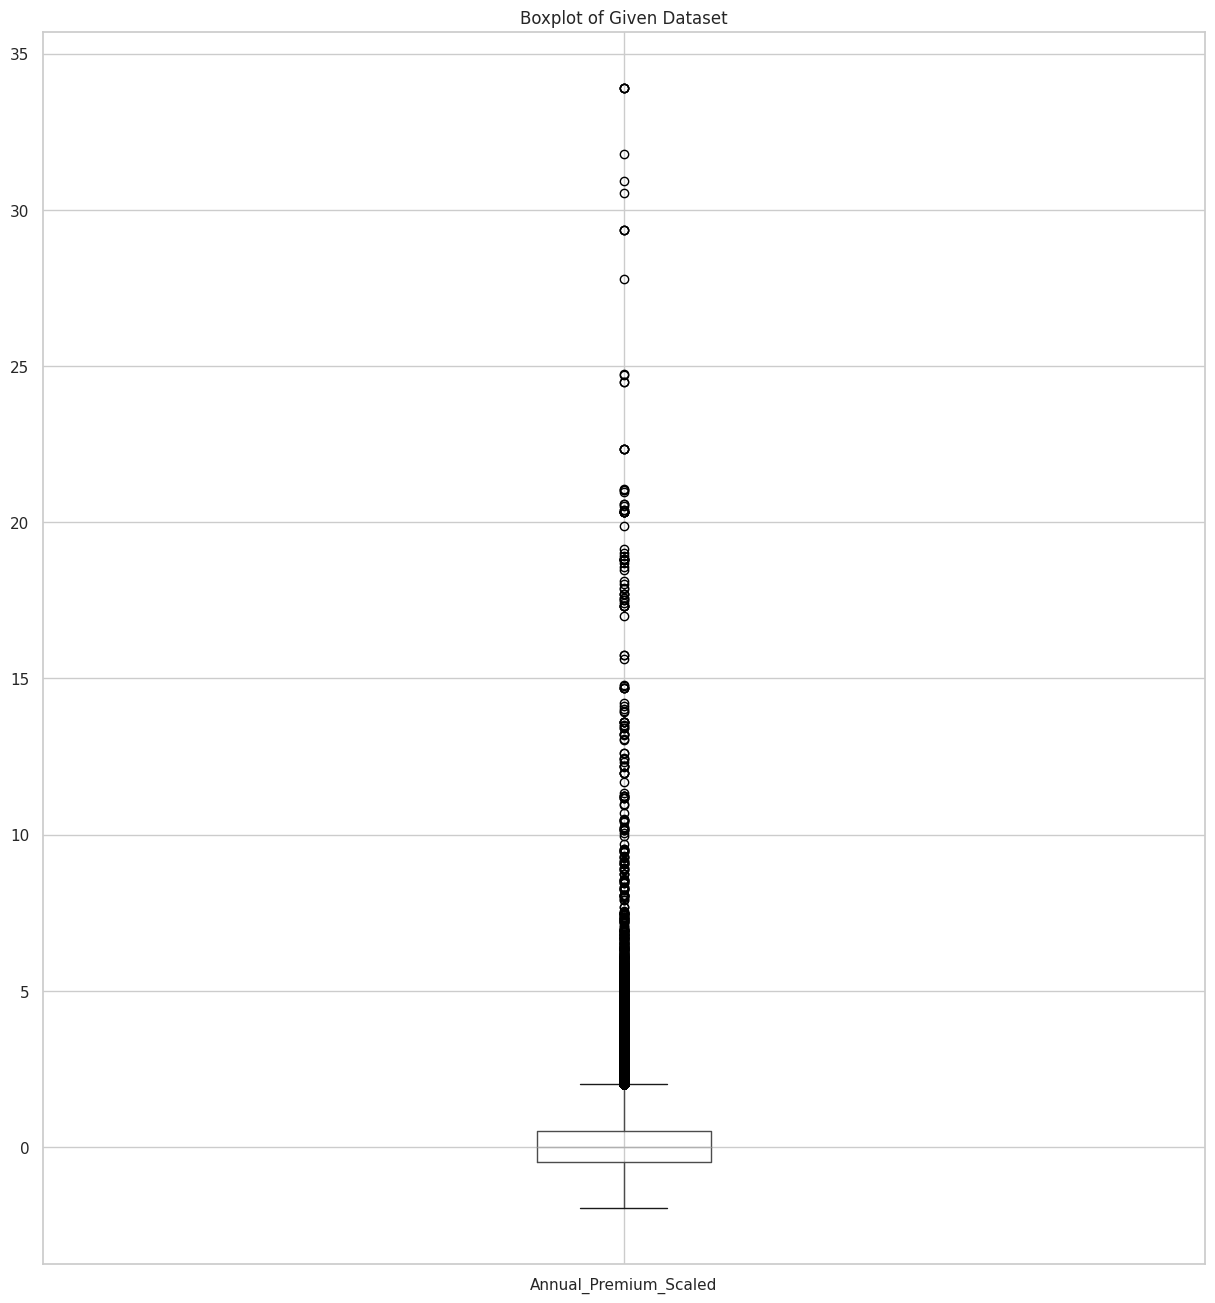

In [39]:
fig = plt.figure(figsize =(15, 16))
scaler = RobustScaler()
train2=train
train2['Annual_Premium_Scaled'] = scaler.fit_transform(train2[['Annual_Premium']])

# train2['log_annual_premium']=np.log(train2['Annual_Premium'])
ax = train2[['Annual_Premium_Scaled']].boxplot()
ax.set_title("Boxplot of Given Dataset")
plt.show()

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler



In [41]:
category_tasks = Pipeline(
steps = [
    ('impute_cat', SimpleImputer(strategy='most_frequent')),
    ('ohe',OneHotEncoder(handle_unknown='ignore')) # categetoy encoding
])

numeric_tasks = Pipeline(
steps = [
    ('impute_num', SimpleImputer(strategy='median')),
    ('scale',RobustScaler()) # standard scaler
])


preprocess = ColumnTransformer(
    transformers =[
        ('cat_encode',category_tasks,cat_cols),
        ('num_encode',numeric_tasks,num_cols)
    ]
)

In [42]:
model_pipeline = Pipeline(
steps=[
    ('preprocess',preprocess),
    ('model',LogisticRegression())
])

In [43]:
x = train.drop(columns=ignored_cols+target_col)
x.head(2)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,log_annual_premium,Annual_Premium_Scaled
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,10.607921,0.585862
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,10.420375,0.124508


In [44]:
y=train['Response']


In [45]:
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.2, random_state=1)


In [46]:
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)


(304887, 12) (76222, 12) (304887,) (76222,)


In [47]:
over_sampling = RandomOverSampler()
train_x_os, train_y_os = over_sampling.fit_resample(train_x,train_y)
train_y_os.value_counts()

,count
Response,
0,267347
1,267347


In [48]:
model_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_encode',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage']),
                                                 ('num_encode',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Region_Code',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel',
                                                   'Vintage'])])),
                ('model', LogisticRegression())])

In [49]:
def model_train_val_eval(train_X,test_x,train_y,test_y,model_pipeline):

    predicted_train_tgt = model_pipeline.predict(train_X)
    predicted_test_tgt = model_pipeline.predict(test_x)

    print('Train AUC', roc_auc_score(train_y,predicted_train_tgt),sep='\n')
    print('Valid AUC', roc_auc_score(test_y,predicted_test_tgt),sep='\n')

    print('Train cnf_matrix', confusion_matrix(train_y,predicted_train_tgt),sep='\n')
    print('Valid cnf_matrix', confusion_matrix(test_y,predicted_test_tgt),sep='\n')

    print('Train cls_rep', classification_report(train_y,predicted_train_tgt),sep='\n')
    print('Valid cls rep', classification_report(test_y,predicted_test_tgt),sep='\n')

    # plot roc-auc
    y_pred_proba = model_pipeline.predict_proba(test_x)[:,1]
    plt.figure()
    fpr, tpr, thrsh = roc_curve(test_y,y_pred_proba)
    #roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr)
    plt.show()

In [50]:
params = [
    # {
    # 'model': [LogisticRegression()],
    # 'model__penalty':['l2','l1'],
    # 'model__C':[0.01, 0.1, 1, 5]
    # },

# {
#     'model': [SVC()],
#         'model__C': [0.1, 1, 10],
#         'model__gamma': ['scale', 'auto'],
#         'model__kernel': ['linear', 'rbf', 'poly']
#     },
    # For Random Forest Classifier
    # {
    #     'model': [RandomForestClassifier()],
    #     'model__n_estimators': [50, 100, 200],
    #     'model__max_features': ['auto', 'sqrt', 'log2'],
    #     'model__max_depth': [None, 10, 20, 30],
    #     'model__min_samples_split': [2, 5, 10]
    # }
    # ,
    # {
    # 'model': [DecisionTreeClassifier()],
    # 'model__max_depth':[3,5]
    # },
    {
    'model': [StackingClassifier(
    estimators=[
        ['sclf1',RandomForestClassifier()],
        ['sclf2',GradientBoostingClassifier()],
        ['sclf3',AdaBoostClassifier()],],
        final_estimator=LogisticRegression()

    )],
    'model__sclf1__max_depth':[4,8],
    'model__sclf2__n_estimators':[12,15,25],
    'model__sclf3__n_estimators':[3,5,35],
    }
,
    {
        'model': [XGBClassifier()],
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 4, 5],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.8, 1.0]
    }
]

In [53]:
grid = GridSearchCV(estimator=model_pipeline, param_grid=params,
                    cv=2, scoring='roc_auc',verbose=2)

In [54]:
grid.fit(train_x_os, train_y_os)


Fitting 2 folds for each of 54 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=12, model__sclf3__n_estimators=3; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=12, model__sclf3__n_estimators=3; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=12, model__sclf3__n_estimators=5; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=12, model__sclf3__n_estimators=5; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=12, model__sclf3__n_estimators=35; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=12, model__sclf3__n_estimators=35; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=15, model__sclf3__n_estimators=3; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=15, model__sclf3__n_estimators=3; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=15, model__sclf3__n_estimators=5; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=15, model__sclf3__n_estimators=5; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=15, model__sclf3__n_estimators=35; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=15, model__sclf3__n_estimators=35; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=25, model__sclf3__n_estimators=3; total time= 1.5min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=25, model__sclf3__n_estimators=3; total time= 1.5min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=25, model__sclf3__n_estimators=5; total time= 1.5min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=25, model__sclf3__n_estimators=5; total time= 1.5min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=25, model__sclf3__n_estimators=35; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=4, model__sclf2__n_estimators=25, model__sclf3__n_estimators=35; total time= 1.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=12, model__sclf3__n_estimators=3; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=12, model__sclf3__n_estimators=3; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=12, model__sclf3__n_estimators=5; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=12, model__sclf3__n_estimators=5; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=12, model__sclf3__n_estimators=35; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=12, model__sclf3__n_estimators=35; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=15, model__sclf3__n_estimators=3; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=15, model__sclf3__n_estimators=3; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=15, model__sclf3__n_estimators=5; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=15, model__sclf3__n_estimators=5; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=15, model__sclf3__n_estimators=35; total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=15, model__sclf3__n_estimators=35; total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=25, model__sclf3__n_estimators=3; total time= 1.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=25, model__sclf3__n_estimators=3; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=25, model__sclf3__n_estimators=5; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=25, model__sclf3__n_estimators=5; total time= 2.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=25, model__sclf3__n_estimators=35; total time= 2.5min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[CV] END model=StackingClassifier(estimators=[['sclf1', RandomForestClassifier()],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()]],
                   final_estimator=LogisticRegression()), model__sclf1__max_depth=8, model__sclf2__n_estimators=25, model__sclf3__n_estimators=35; total time= 2.5min
[CV] END model=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=na

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_encode',
                                                                         Pipeline(steps=[('impute_cat',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Vehicle_Age',
                                                                          'Vehicle_Damage']),
                                                                        ('num_encode',
                                                                         Pipeline(steps=[('impute_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('sca...
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=None,
                                                  n_jobs=None,
                                                  num_parallel_tree=None,
                                                  random_state=None, ...)],
                          'model__learning_rate': [0.01, 0.1, 0.2],
                          'model__max_depth': [3, 4, 5],
                          'model__n_estimators': [100, 200],
                          'model__subsample': [0.8, 1.0]}],
             scoring='roc_auc', verbose=2)

In [55]:
final_model=grid.best_estimator_
import joblib
joblib.dump(final_model,'/content/drive/MyDrive/ColabNotebooks/megahack1/model.pkl')

['/content/drive/MyDrive/ColabNotebooks/megahack1/model.pkl']

Train AUC
0.8153822560193307
Valid AUC
0.8008658671526342
Train cnf_matrix
[[184455  82892]
 [ 15822 251525]]
Valid cnf_matrix
[[46197 20855]
 [  800  8370]]
Train cls_rep
              precision    recall  f1-score   support

           0       0.92      0.69      0.79    267347
           1       0.75      0.94      0.84    267347

    accuracy                           0.82    534694
   macro avg       0.84      0.82      0.81    534694
weighted avg       0.84      0.82      0.81    534694

Valid cls rep
              precision    recall  f1-score   support

           0       0.98      0.69      0.81     67052
           1       0.29      0.91      0.44      9170

    accuracy                           0.72     76222
   macro avg       0.63      0.80      0.62     76222
weighted avg       0.90      0.72      0.77     76222



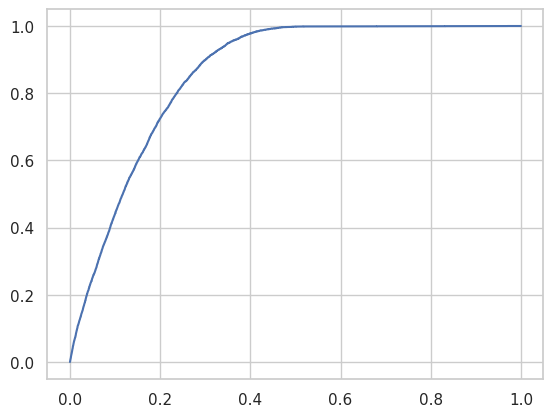

In [56]:
model_train_val_eval(train_x_os,test_x,train_y_os,test_y,final_model)


In [57]:
model_pipeline_hyper = Pipeline(
steps=[
    ('preprocess',preprocess),
    ('model',final_model)
])

In [58]:
joblib.dump(model_pipeline_hyper,'/content/drive/MyDrive/ColabNotebooks/megahack1/model_pipeline_hyper.pkl')

['/content/drive/MyDrive/ColabNotebooks/megahack1/model_pipeline_hyper.pkl']